## Transient Universe Nested sampling


In [53]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
#import pymc3
import corner

import dynesty
from dynesty import plotting as dyplot

# Regression
from sklearn.gaussian_process import GaussianProcessRegressor

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

Text(0.5, 1.0, 'Transient flux')

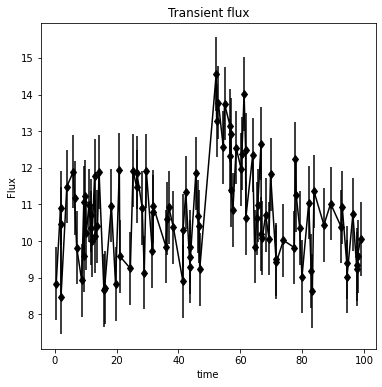

In [2]:
file = np.load('transient.npy')

time = file[:,0]
flux = file[:,1]
err_flux = file[:,2]

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

### Models and functions

***Burst model***

Burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


***Gaussian model***

Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$


In [3]:
# models ----------------------------------------------------------------------

# burst model:
def burst_model(params,t):
    '''burst model for the transient flux'''
    # extract the parameters
    t0 = params[0]
    b = params[1]
    A = params[2]
    alpha = params[3]
    
    # define the model
    func = np.zeros(len(t))
    
    for i in range(len(t)):
        if(t[i]<t0):
            func[i] = b
        elif(t[i]>=t0):
             func[i] = b + A*np.exp(-alpha*(t[i]-t0))
        
    return func

# Gaussian model:
def Gauss_model(params,t):
    '''gaussian model for the transient flux'''
    # extract the parameters
    t0 = params[0]
    b = params[1]
    A = params[2]
    sigma_w = params[3]
    
    # define the model
    func = np.zeros(len(t))
    
    for i in range(len(t)):
        func[i] = b + A*np.exp(-(t[i]-t0)**2/(2*sigma_w**2))
        
    return func

# prior -------------------------------------------------------------------------------
def prior_trans(params,model_name):
    prior_t0 = scipy.stats.uniform(30,70).ppf(params[0])
    prior_b = scipy.stats.uniform(0,20).ppf(params[1])
    prior_A = scipy.stats.uniform(0,20).ppf(params[2])
    
    if(model_name=='burst'):
        prior_Alpha = scipy.stats.uniform(np.exp(-5),np.exp(2)).ppf(params[3])
        prior_4 = prior_Alpha
        
    if(model_name=='gauss'):
        prior_sigmaw = scipy.stats.uniform(0,100).ppf(params[3])
        prior_4 = prior_sigmaw
    
    if not np.isfinite(np.array([prior_t0,prior_b,prior_A,prior_4]).any()):
        return -np.inf
    
    else:
        return np.array([prior_t0,prior_b,prior_A,prior_4])
    
    
# log-Likelihood --------------------------------------------------------------------
def logL(params,model_name):
    """log-likelihood of the model"""
    if(model_name=='burst'):
        model=burst_model
        
    if(model_name=='gauss'):
        model=Gauss_model
    
    # load the data
    x,y,err_y = np.array([time,flux,err_flux])
    
    # apply the model
    y_fit = model(params,x)
    
    #print(params)
    #logL_vector.append(sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)))
    
    return sum(-np.log(np.sqrt(2*np.pi)*args[2]) + scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.



In [4]:
# "Static" nested sampling: burst model
ndim = 4

sampler_burst = dynesty.NestedSampler(logL, prior_trans, ndim, logl_args=['burst'],ptform_args=['burst'])
sampler_burst.run_nested()
sresults_burst = sampler_burst.results

7472it [54:29,  2.29it/s, +500 | bound: 109 | nc: 1 | ncall: 103194 | eff(%):  7.763 | loglstar:   -inf < -232.572 <    inf | logz: -246.721 +/-  0.166 | dlogz:  0.001 >  0.509]


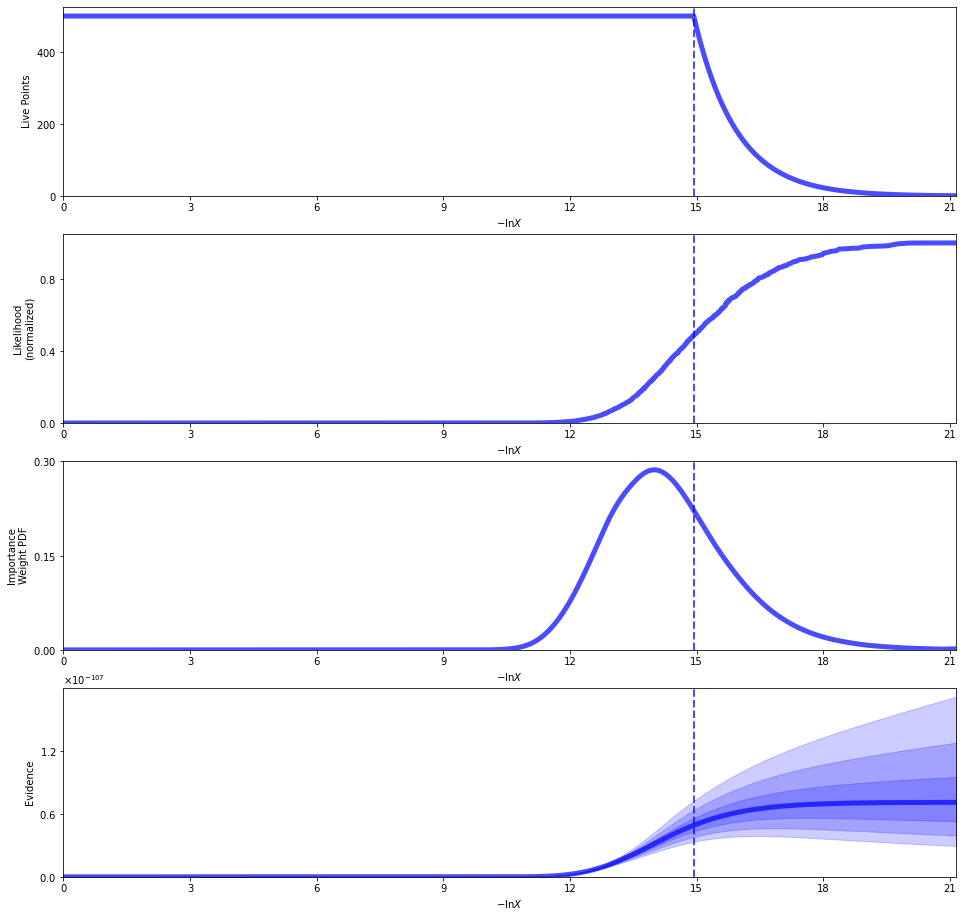

In [5]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(sresults_burst)

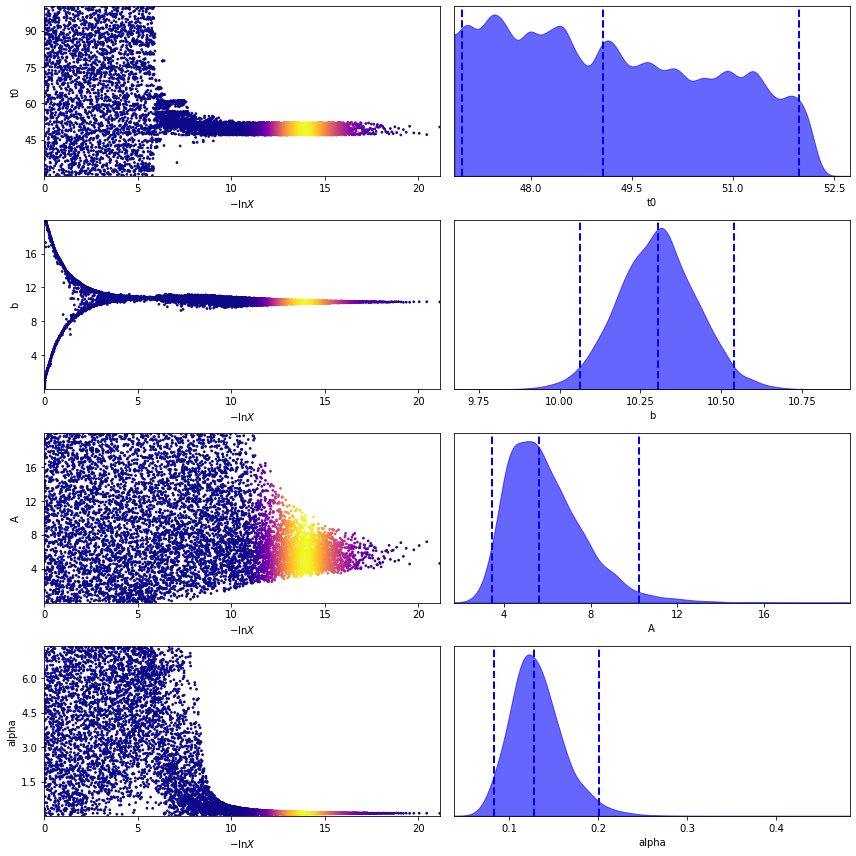

In [6]:
burst_params_name = np.array(['t0','b','A','alpha'])

tfig, taxes = dyplot.traceplot(sresults_burst,labels=burst_params_name)

tfig.tight_layout()

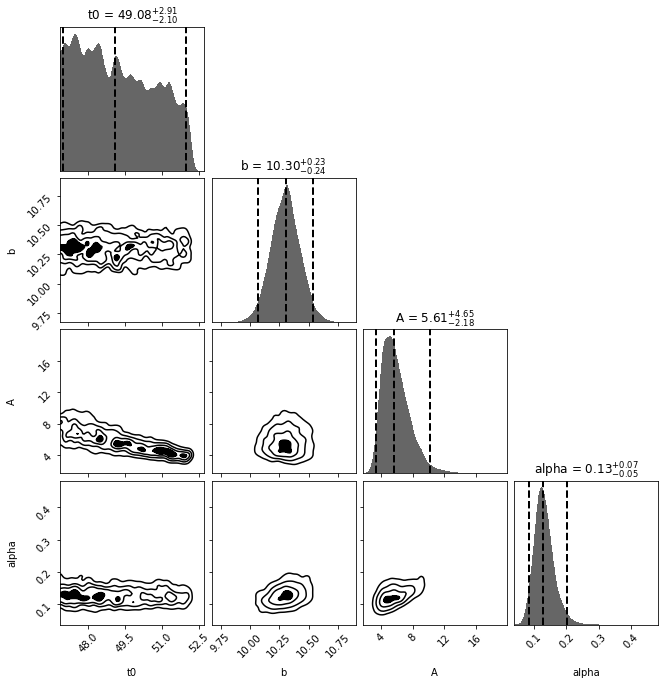

In [7]:
cfig, caxes = dyplot.cornerplot(sresults_burst,labels=burst_params_name,show_titles=True)

These results for the estimated parameters is compatible with the ones obtained through emcee

### Gaussian model

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)


In [8]:
# "Static" nested sampling.
ndim = 4

sampler_gauss = dynesty.NestedSampler(logL, prior_trans, ndim,logl_args=['gauss'],ptform_args=['gauss'])
sampler_gauss.run_nested()
sresults_gauss = sampler_gauss.results

7743it [24:54,  5.18it/s, +500 | bound: 79 | nc: 1 | ncall: 80145 | eff(%): 10.350 | loglstar:   -inf < -236.194 <    inf | logz: -250.970 +/-  0.171 | dlogz:  0.001 >  0.509]


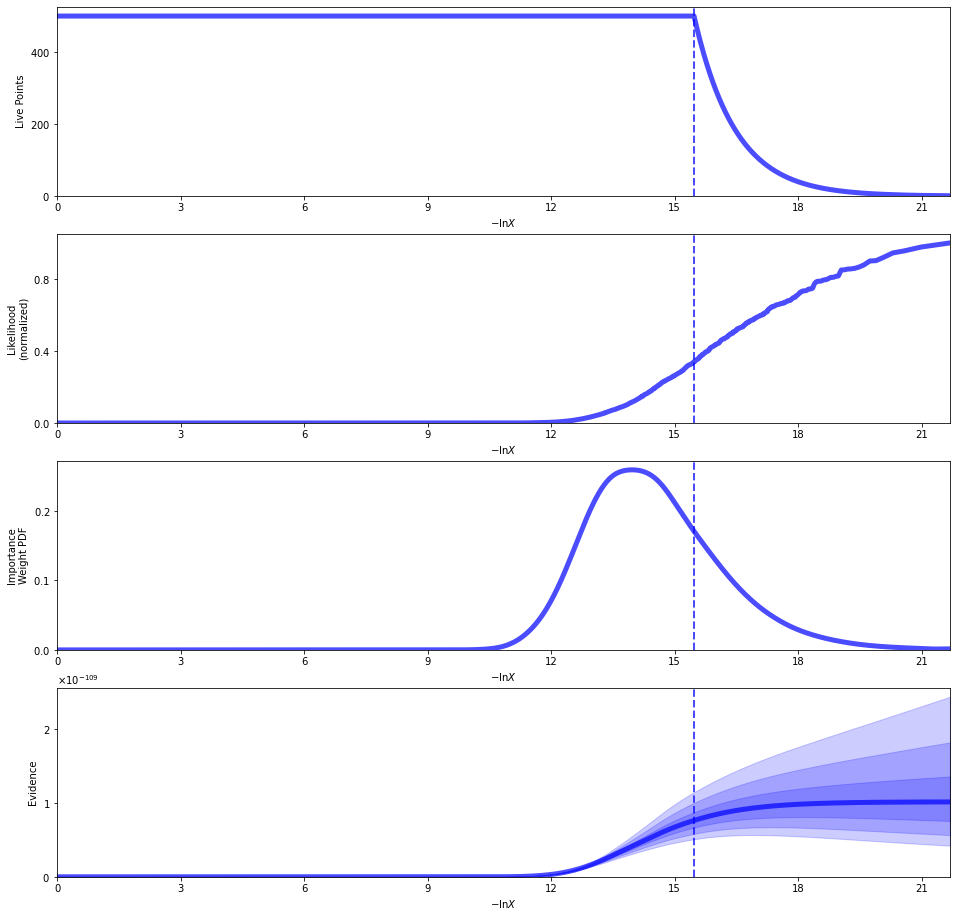

In [9]:
rfig, raxes = dyplot.runplot(sresults_gauss)

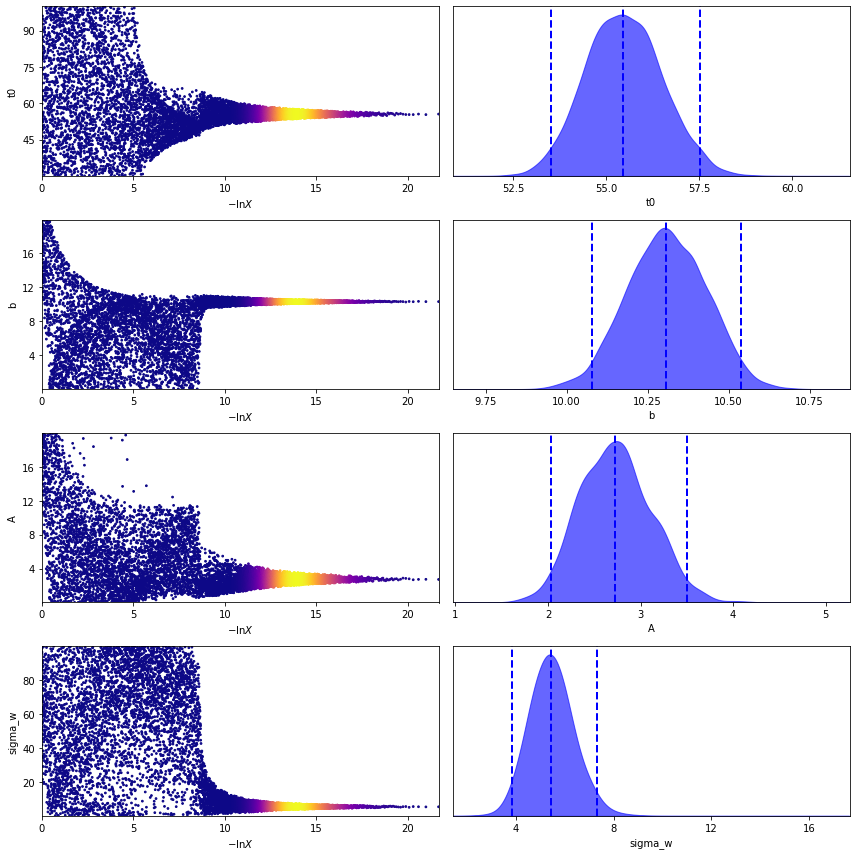

In [10]:
gauss_params_name = np.array(['t0','b','A','sigma_w'])

tfig, taxes = dyplot.traceplot(sresults_gauss,labels=gauss_params_name)

tfig.tight_layout()

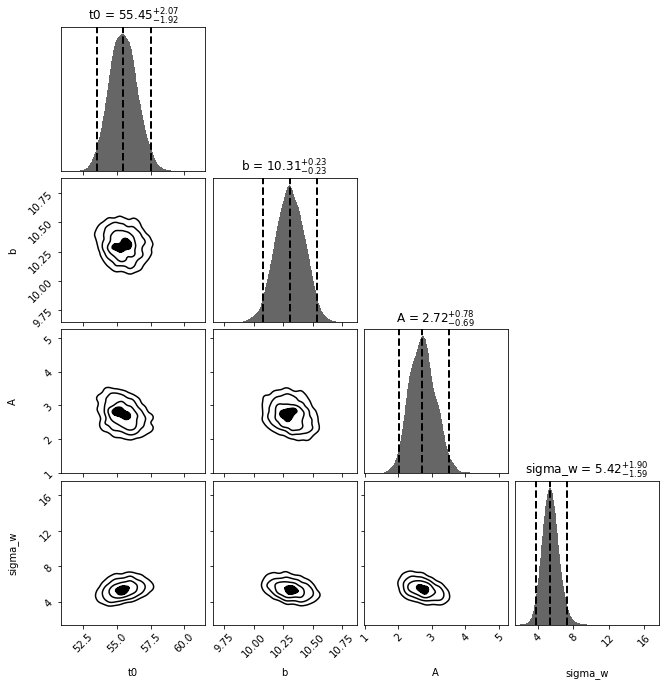

In [11]:
cfig, caxes = dyplot.cornerplot(sresults_gauss,labels=gauss_params_name,show_titles=True)


9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

### Burst Bayesan evidence and results

In [22]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples_burst = sresults_burst.samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])  # normalized weights

# Resample weighted samples:
samples_equal_burst = dyfunc.resample_equal(samples_burst,weights_burst)

evidence_burst = sresults_burst.logz[-1] #evidence
err_E_burst = sresults_burst.logzerr[-1] #evidence error
print("Bayesian evidence for burst model", np.exp(evidence_burst), '+/-',np.exp(err_E_burst))


# Compute 10%-90% quantiles.
quantiles_burst = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_burst)
             for samps in samples_burst.T]
print('68% parameter credible regions are:\n ' + str(quantiles_burst) + '\n')

# Compute weighted mean and covariance.
mean_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)
print('Mean and covariance of parameters for the burst model are: \n\n' + str(mean_burst) + '\n\n' + str(cov_burst))

Bayesian evidence for burst model 7.083782609013241e-108 +/- 1.3423386701556324
68% parameter credible regions are:
 [[47.52232365322905, 51.039183267725164], [10.182812617777458, 10.424809581436083], [4.259866062144021, 7.5946784085332375], [0.10372491186907352, 0.15869041312323975]]

Mean and covariance of parameters for the burst model are: 

[49.22333234 10.30225232  5.93331271  0.13133303]

[[ 2.26730035e+00 -5.25175153e-03 -1.85145175e+00 -2.16769361e-03]
 [-5.25175153e-03  1.47591406e-02  1.60587699e-02  1.37188631e-03]
 [-1.85145175e+00  1.60587699e-02  3.23357980e+00  3.08642449e-02]
 [-2.16769361e-03  1.37188631e-03  3.08642449e-02  8.83014798e-04]]


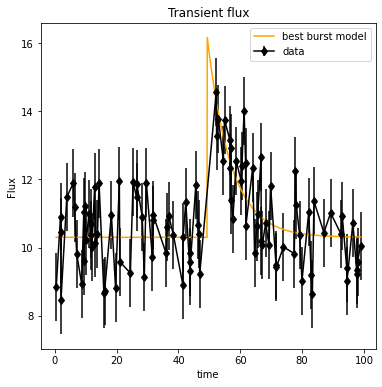

In [23]:
# plot the resulting best-burst model 

t_grid = np.linspace(time.min(),time.max(),1000)
burst_fit = burst_model(mean_burst,t_grid) 

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

plt.plot(t_grid,burst_fit,label='best burst model',color='orange')
plt.legend()

Text(0.5, 1.0, 'nested resampling burst model')

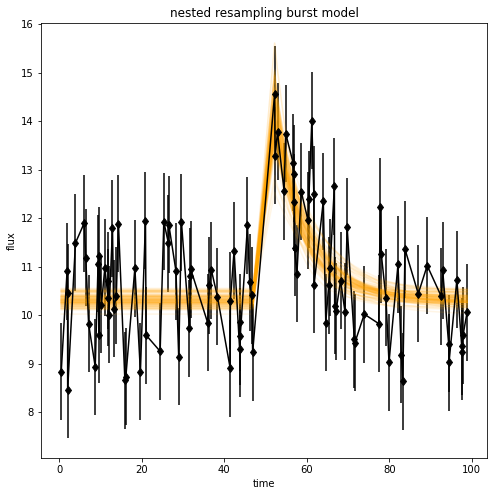

In [34]:
# study the spread of the distribution through the re-sampled chain
N_resample = 100

cloned_burst = np.zeros([N_resample],dtype=object)

figure = plt.figure(figsize=(8,8))

for i in range(N_resample):
    idx_chain = np.random.choice(np.arange(0,samples_equal_burst.shape[0]))
    cloned_burst[i] = burst_model(samples_equal_burst[idx_chain],time)
    plt.plot(time,cloned_burst[i],color='orange',alpha=0.1)

plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')

plt.xlabel("time")
plt.ylabel("flux")
plt.title('nested resampling burst model')
#plt.legend(loc='lower right')

In [35]:
sresults_burst.summary()

Summary
nlive: 500
niter: 7472
ncall: 102694
eff(%):  7.763
logz: -246.721 +/-  0.294


### Gauss Bayesan evidence and results

In [37]:
# Extract sampling results.
samples_gauss = sresults_gauss.samples
weights_gauss = np.exp(sresults_gauss.logwt - sresults_gauss.logz[-1])  # normalized weights

# Resample weighted samples:
samples_equal_gauss = dyfunc.resample_equal(samples_gauss,weights_gauss)

evidence_gauss = sresults_gauss.logz[-1] #evidence
err_E_gauss = sresults_gauss.logzerr[-1] #evidence error
print("Bayesian evidence for gauss model", np.exp(evidence_gauss), '+/-',np.exp(err_E_gauss))

# Compute 10%-90% quantiles.
quantiles_gauss = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gauss)
             for samps in samples_gauss.T]
print('68% parameter credible regions are:\n ' + str(quantiles_gauss) + '\n')

# Compute weighted mean and covariance.
mean_gauss, cov_gauss = dyfunc.mean_and_cov(samples_gauss, weights_gauss)
print('Mean and covariance of parameters for the gauss model are: \n\n' + str(mean_gauss) + '\n\n' + str(cov_gauss))

Bayesian evidence for gauss model 1.012029107883044e-109 +/- 1.3398347923717882
68% parameter credible regions are:
 [[54.480504134891646, 56.485972968548175], [10.185919048230911, 10.434393430205635], [2.3383397599061055, 3.1267814116441413], [4.587900573470214, 6.31525442585453]]

Mean and covariance of parameters for the gauss model are: 

[55.47686311 10.30871293  2.72827196  5.45779951]

[[ 1.03160451 -0.01710336 -0.12237905  0.27825199]
 [-0.01710336  0.01487785 -0.01034474 -0.03751164]
 [-0.12237905 -0.01034474  0.14883555 -0.14547895]
 [ 0.27825199 -0.03751164 -0.14547895  0.80369107]]


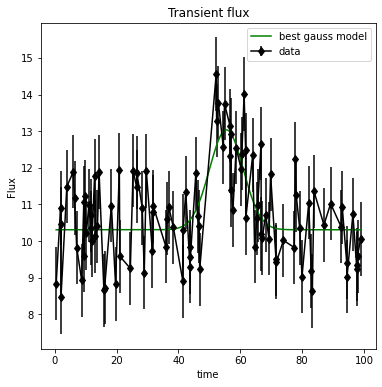

In [38]:
# plot the resulting best-gauss model 

t_grid = np.linspace(time.min(),time.max(),1000)
gauss_fit = Gauss_model(mean_gauss,t_grid) 

fig = plt.figure(figsize=(6,6))

#plt.plot(time,flux,c='black')
#plt.scatter(time,flux,c='black',s=10)
plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')
plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Transient flux')

plt.plot(t_grid,gauss_fit,label='best gauss model',color='green')
plt.legend()

Text(0.5, 1.0, 'nested resampling gauss model')

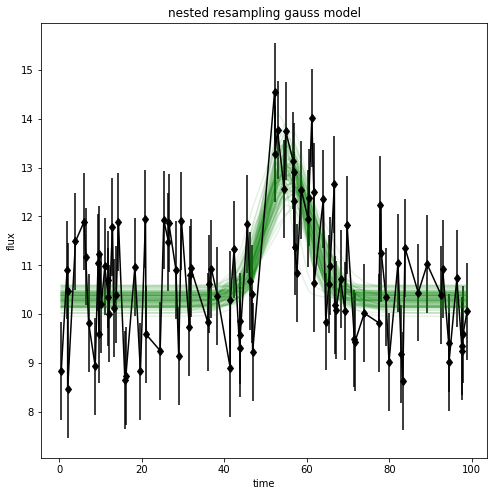

In [41]:
# study the spread of the distribution through the re-sampled chain
N_resample = 100

cloned_gauss = np.zeros([N_resample],dtype=object)

figure = plt.figure(figsize=(8,8))

for i in range(N_resample):
    idx_chain = np.random.choice(np.arange(0,samples_equal_gauss.shape[0]))
    cloned_gauss[i] = Gauss_model(samples_equal_gauss[idx_chain],time)
    plt.plot(time,cloned_gauss[i],color='green',alpha=0.1)

plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')

plt.xlabel("time")
plt.ylabel("flux")
plt.title('nested resampling gauss model')
#plt.legend(loc='lower right')

In [42]:
sresults_gauss.summary()

Summary
nlive: 500
niter: 7743
ncall: 79645
eff(%): 10.350
logz: -250.970 +/-  0.293


Let's compute the Odds ratio to compare the two models. The Odds ratio is defined as the ratio of the two posterior distributions, integrated over the parameter space:

$$ O_{21} = \frac{p(M_2|D,I)}{p(M_1|D,I)} = \frac{p(D|M_2,I)p(M_2|I)}{p(D|M_1,I)p(M_1|I)} $$

where we can define the Bayes factor:

$$ B_{21} = \frac{p(D|M_2,I)}{p(D|M_1,I)}  $$

That is the ratio of the evidences:

$$ E_i = p(D|M_i,I) = \int{p(D|M_i,\theta,I)p(\theta|M_i,I)d\theta} $$

Since we can compute the Bayes factor as:

$$B_{21} = \frac{\exp{(E_1)}}{\exp{(E_2)}}$$

Then, the uncertainty associated to $B_{21}$ can be computed as:

$$ \sigma_{B_{21}} = \sqrt{\Bigl(\frac{\partial B_{21}}{\partial{E_1}}\Bigr)^2\sigma_{E_1}^2 + \Bigl(\frac{\partial B_{21}}{\partial{E_2}}\Bigr)^2\sigma_{E_2}^2} $$

That results in:

$$ \sigma_{B_{21}} = \sqrt{(B_{21})^2\sigma_{E_1}^2 + (-B_{21})^2\sigma_{E_2}^2} $$

In [51]:
evidence_ratio = np.exp(evidence_burst)/np.exp(evidence_gauss)

err_evidence_r = np.sqrt(evidence_ratio**2 * np.exp(err_E_burst)**2 + evidence_ratio**2 * np.exp(err_E_gauss)**2)

print('Bayes factor:',evidence_ratio, '+/-',err_evidence_r)

Bayes factor: 69.99583859629347 +/- 132.7529784544074


Which proposes a 'very strong' evidence in favour of the burst model against the gaussian one (also if the error is huge).

This is the ratio of the evidences, but not the full Odds ratio since we are missing the prior ratio of the models, that can be approximate to $1$

### Try regression with GPR

In [55]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF,ConstantKernel

In [84]:
X = time[:,np.newaxis]
y = flux
dy = err_flux

In [85]:
# let's try naively

gpr_kernel = ConstantKernel(1,constant_value_bounds=(1e-3,1e3)) * RBF(0.1, length_scale_bounds=(1e-3,1e3))
gp_reg = GaussianProcessRegressor(kernel=gpr_kernel,alpha=(dy)**2)
gp_reg.fit(X,y)

y_pred,dy_pred = gp_reg.predict(X,return_std=True)

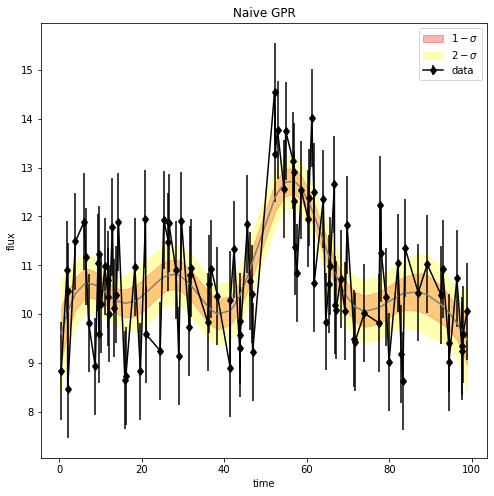

In [126]:
figure = plt.figure(figsize=(8,8))

plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')

plt.plot(time, y_pred, '-', color='gray')

plt.fill_between(time, y_pred-dy_pred, y_pred+dy_pred, 
                color='red', alpha=0.3,label='$1-\sigma$')

plt.fill_between(time, y_pred-2*dy_pred, y_pred+2*dy_pred, 
                color='yellow', alpha=0.3,label='$2-\sigma$')


plt.xlabel("time")
plt.ylabel("flux")
plt.title('Naive GPR')
plt.legend()

In [88]:
def error_func(y_true, y_m,sigma_y):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2/sigma_y**2)) 

In [119]:
# let's try by cross validating:

ls_range = np.linspace(0.005,1,10)
const_range = np.linspace(0.5,10,10)

err_cv_gpr = np.empty([len(const_range),len(ls_range)])
err_train_gpr = np.empty([len(const_range),len(ls_range)])

for c,j in zip(const_range,np.arange(0,len(const_range))):
    for ls,i in zip(ls_range,np.arange(0,len(ls_range))):
        # summed kernel
        # constant kernel added to RBF modifies the mean of the Gaussian process.
        kernel = ConstantKernel(c,constant_value_bounds='fixed') + RBF(length_scale=ls,length_scale_bounds='fixed') 
        # cross validation
        n_splits=10
        kf = KFold(n_splits) # sample splitting
    
        err_train_i = []
        err_cv_i = []
    
        # iterating over the n_splits
        for train, test in kf.split(X):
            model = GaussianProcessRegressor(kernel=kernel,alpha=(dy[train])**2)
            
            # define the model given the splitted data
            model.fit(X[train],y[train]) 
        
            #define the variables to compute the errors
            y_train = model.predict(X[train])
            y_cv = model.predict(X[test])
            y_true_train = y[train]
            y_true_cv = y[test]
            dy_train = dy[train]
            dy_test = dy[test]
        
            # compute the errors on the training and cross-validation set for a given set
            err_train_i.append(error_func(y_true_train,y_train,dy_train)) # take the square to sum
            err_cv_i.append(error_func(y_true_cv,y_cv,dy_test)) # take the square to sum
        
        err_train_gpr[j,i] = np.mean(err_train_i)
        err_cv_gpr[j,i] = np.mean(err_cv_i)

Text(0.5, 1.0, 'Training error 2D distribution Const+RBF kernel')

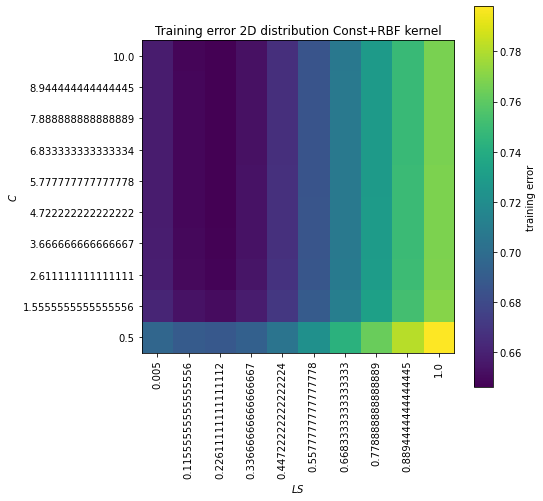

In [120]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_train_gpr,origin='lower')
plt.colorbar(label='training error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('Training error 2D distribution Const+RBF kernel')

Text(0.5, 1.0, 'CV error 2D distribution Const+RBF kernel')

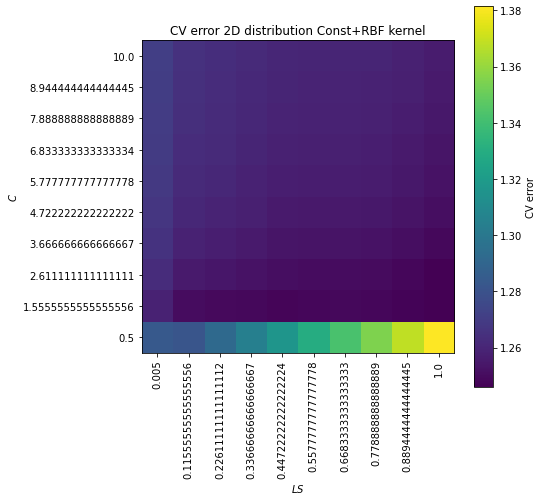

In [121]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_cv_gpr,origin='lower')
plt.colorbar(label='CV error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('CV error 2D distribution Const+RBF kernel')

In [122]:
min_C_idx,min_ls_idx = np.where(err_cv_gpr == np.min(err_cv_gpr))

best_C_gpr = const_range[min_C_idx[0]]
best_ls_gpr = ls_range[min_ls_idx[0]]

print('best C:',best_C_gpr)
print('best ls:',best_ls_gpr)

best C: 2.611111111111111
best ls: 1.0


In [128]:
best_kernel_gpr = ConstantKernel(best_C_gpr,constant_value_bounds='fixed') + RBF(best_ls_gpr, length_scale_bounds='fixed')
best_gpr = GaussianProcessRegressor(kernel=best_kernel_gpr,alpha=(dy)**2)
best_gpr.fit(X,y)

y_pred_best,dy_pred_best = best_gpr.predict(X,return_std=True)

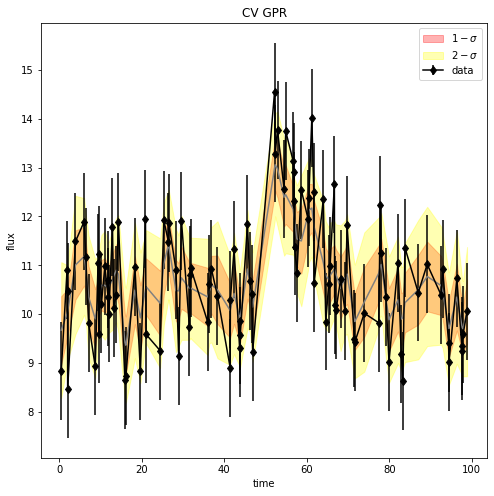

In [129]:
figure = plt.figure(figsize=(8,8))

plt.errorbar(time,flux,err_flux,c='black',marker='d',label='data')

plt.plot(time, y_pred_best, '-', color='gray')

plt.fill_between(time, y_pred_best-dy_pred_best, y_pred_best+dy_pred_best, 
                color='red', alpha=0.3,label='$1-\sigma$')

plt.fill_between(time, y_pred_best-2*dy_pred_best, y_pred_best+2*dy_pred_best, 
                color='yellow', alpha=0.3,label='$2-\sigma$')


plt.xlabel("time")
plt.ylabel("flux")
plt.title('CV GPR')
plt.legend()

This was achieved with a pure data-driven approach